# Inferring Latent Neural States

Let's analyze some neural data using popular dimensionality reduction methods.
We will use the folloiwng methods with progressively better modeling assumptions.
- PCA (Principal Components Analysis)
  - Gaussian observation
  - Independent identical gaussian noise per neuron
- GPFA (Gaussian Process Factor Analysis)
  - Gaussian observation
  - Unequal magnitude of noise per neuron
  - Smoothness assumption on the latent trajectory
- vLGP (varational latent Gaussian Process)
  - Poisson observation
  - Unequal magnitude of noise per neuron
  - Smoothness assumption on the latent trajectory

## Load Monkey delayed-reaching task data

TODO: remove trial_info_ stuff if not needed. Separate the monkey data visualization to another notebook and make the analysis flexible?

In [1]:
import h5py
import torch
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt
from einops import rearrange
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


baseDir = 'mc_maze/data/'
trial_info_save_path = baseDir + 'info_per_trial_{}.h5'
trial_info_val = pd.read_hdf(trial_info_save_path.format('val'))
trial_info_train = pd.read_hdf(trial_info_save_path.format('train'))

m5 = h5py.File(baseDir + 'monkey.hdf5', 'r')
trial_info_train['color'].values[0]

(0.0, 1.0, 0.10772241105651532, 1.0)

In [2]:
nTrial = m5['pos-train'].shape[0]
nT = m5['pos-train'].shape[1]
nNeuron = m5['spk-train'].shape[2]
dt = 0.005  # 5 ms bin
T = dt * nT

In [3]:
y = m5['spk-train'][()]

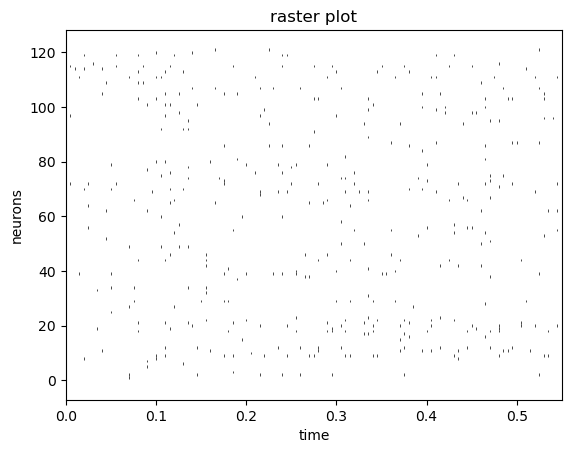

In [4]:
kTrial = 100
raster = []
for kNeuron in range(nNeuron):
    raster.append(np.nonzero(y[kTrial,:,kNeuron])[0]/nT*T)
plt.eventplot(raster, lw=0.5, color='k', label='spikes')
plt.xlim(0, T); plt.xlabel('time'); plt.title('raster plot'); plt.ylabel('neurons');

Text(0.5, 1.0, 'center out reaching trajectory')

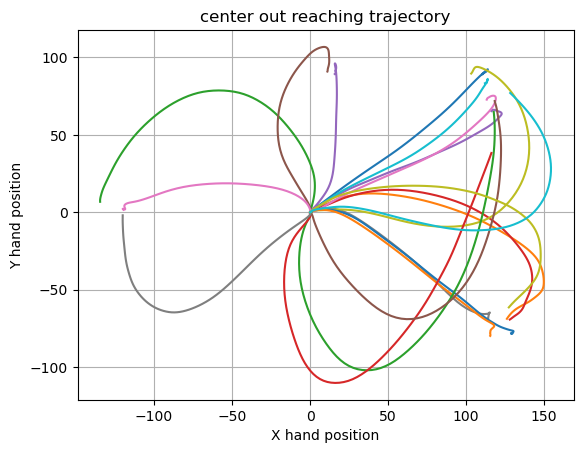

In [5]:
for i in range(100,120):
    plt.plot(m5['pos-train'][i,:,0], m5['pos-train'][i,:,1])
    
plt.xlabel('X hand position'); plt.ylabel('Y hand position'); plt.grid(); plt.title('center out reaching trajectory')

## Load Van der Pol data


In [6]:
# loading data from ./data/vdp_noisy.h5
import sys
sys.path.append("..")

from code_pack.plotting import plot_two_d_vector_field_from_data, raster_to_events
from code_pack.generate_vdp_data import generate_van_der_pol, generate_noisy_van_der_pol
file_name = "vanderpol/data/poisson_obs.h5"

#load data
vdp_data = h5py.File(file_name, 'r')

# dynamics parameters
system_parameters = {}
system_parameters['mu'] = vdp_data['mu']
system_parameters['tau_1'] = vdp_data['tau_1']
system_parameters['tau_2'] = vdp_data['tau_2']
system_parameters['sigma'] = vdp_data['sigma']
system_parameters['scale'] = np.array(vdp_data['scale'])
system_parameters['sigma'] = 0.0




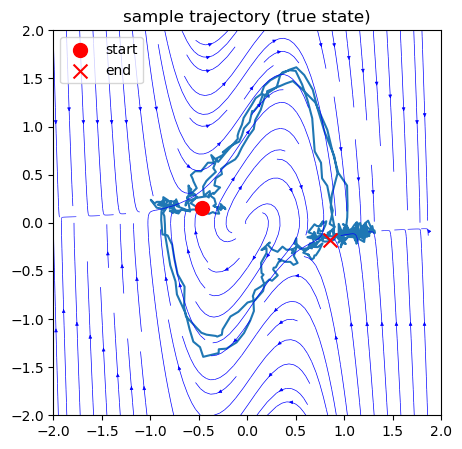

In [10]:
# plotting trajectories of the dataset
X = np.array(vdp_data['X'])
fig, ax = plt.subplots(1, 1, figsize=(5,5))
_ = ax.plot(X[0,:,0], X[0,:,1])
ax.scatter(X[0, 0, 0], X[0, 0, 1], marker='o', color='red', zorder=10, s=100, label='start')
ax.scatter(X[0, -1, 0], X[0, -1, 1], marker='x', color='red', zorder=10, s=100, label='end')
dynamic_func = lambda inp : generate_noisy_van_der_pol(inp, np.array([0.0, 5e-3]), system_parameters)
axs_range = {'x_min':-1.5, 'x_max':1.5, 'y_min':-1.5, 'y_max':1.5}
plot_two_d_vector_field_from_data(dynamic_func, ax, axs_range)

ax.legend()
ax.set_title('sample trajectory (true state)');

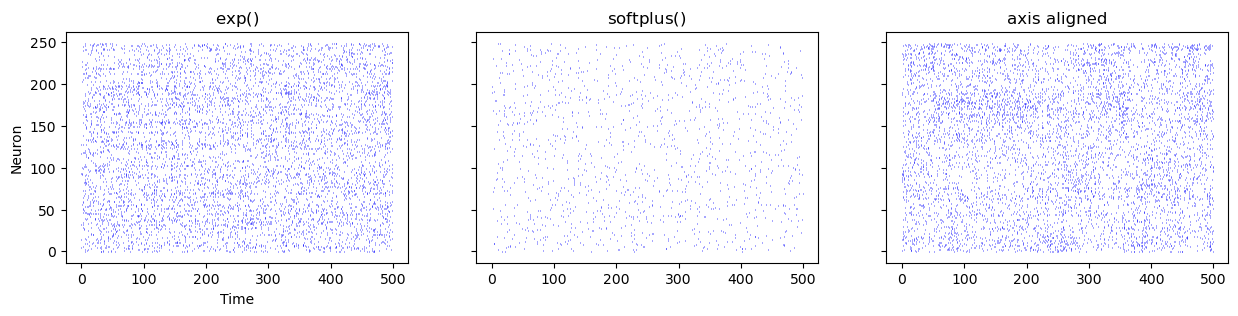

In [11]:
C_tilde = np.array(vdp_data['C_tilde'])
idx = np.lexsort((C_tilde[:,0], C_tilde[:,1]), axis=0) # sort the loading

# showing the spike raster generated from noisy Vdp
fig, axs = plt.subplots(1, 3, figsize=(15, 3), sharex=True, sharey=True)
events = raster_to_events(np.array(vdp_data['Y'])[0,:,:])
events_softplus = raster_to_events(np.array(vdp_data['Y_softplus'])[0,:,:])
events_axis_aligned = raster_to_events(np.array(vdp_data['Y_axis'])[0,:,idx].transpose())
axs[0].eventplot(events, linewidths=0.5, color='blue');
axs[1].eventplot(events_softplus, linewidths=0.5, color='blue');
axs[2].eventplot(events_axis_aligned, linewidths=0.5, color='blue');
axs[0].set_title(f'$\exp()$');
axs[1].set_title(f'softplus$()$');
axs[2].set_title(f'axis aligned');
axs[0].set_xlabel("Time");
axs[0].set_ylabel("Neuron");

## PCA

In order to perform PCA, we first concatenate the the trials such that the data is of the form (trial x time) x neurons. We then smooth the data with a gaussian kernel.

In [12]:
#Choose dataset
use_data = 'vanderpol'


if use_data=='vanderpol':
    vdp_data = h5py.File("vanderpol/data/poisson_obs.h5", 'r')
    y = np.array(vdp_data['Y'])
    gaussian_filter_sigma = 50.0
    nTrial = vdp_data['X'].shape[0]
    nT = vdp_data['X'].shape[1]
    nNeuron = vdp_data['Y'].shape[2]
    dt = 5e-3  # time bin size

elif use_data=='monkey':
    m5 = h5py.File(baseDir + 'monkey.hdf5', 'r')
    y = m5['spk-train'][()]
    dt = 0.005  # 5 ms bin
    gaussian_filter_sigma = 0.050/dt
    nTrial = m5['pos-train'].shape[0]
    nT = m5['pos-train'].shape[1]
    nNeuron = m5['spk-train'].shape[2]
    dt = 0.005  # 5 ms bin
T = dt * nT

In [13]:
# smoothing data with a gaussian kernel
data_stacked = rearrange(y, 'trial time neurons -> (trial neurons) time')
data_smooth = scipy.ndimage.gaussian_filter1d(input = data_stacked, sigma=gaussian_filter_sigma, axis=1)
data_smooth = rearrange(data_smooth, '(trial neurons) time -> (trial time) neurons', trial=nTrial, neurons=nNeuron)

In [14]:
data_centered = data_smooth - np.mean(data_smooth, axis=0)

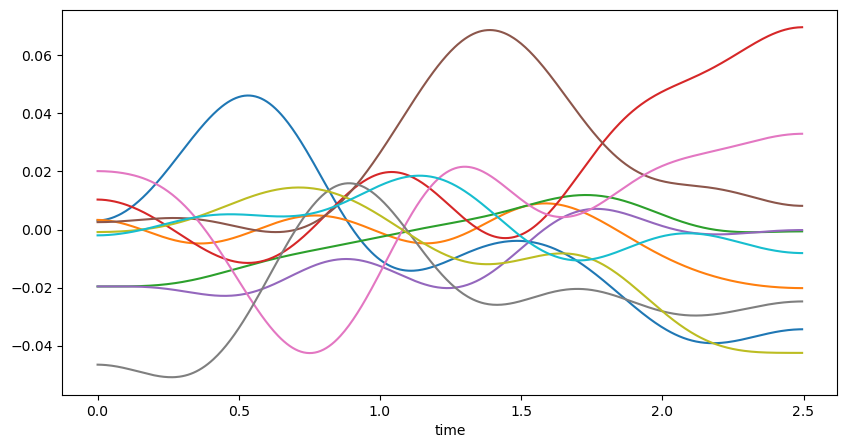

In [15]:
tidx = slice(nT,2*nT)
fig, ax = plt.subplots(1, 1, figsize =(10, 5))
tr = np.arange(0, T, dt)
ax.plot(tr, data_centered[tidx, 0:10]);
ax.set_xlabel("time");

In [16]:
# PCA using SVD
u, s, vh = np.linalg.svd(data_centered, full_matrices=False)
u.shape, s.shape

((125000, 250), (250,))

In [17]:
norm_sv = s**2/np.sum(s**2)
top2sv = np.sum(norm_sv[:2])
print("Total observations explained by the first two principal components: {0:.2f}%".format(top2sv*100))

Total observations explained by the first two principal components: 22.74%


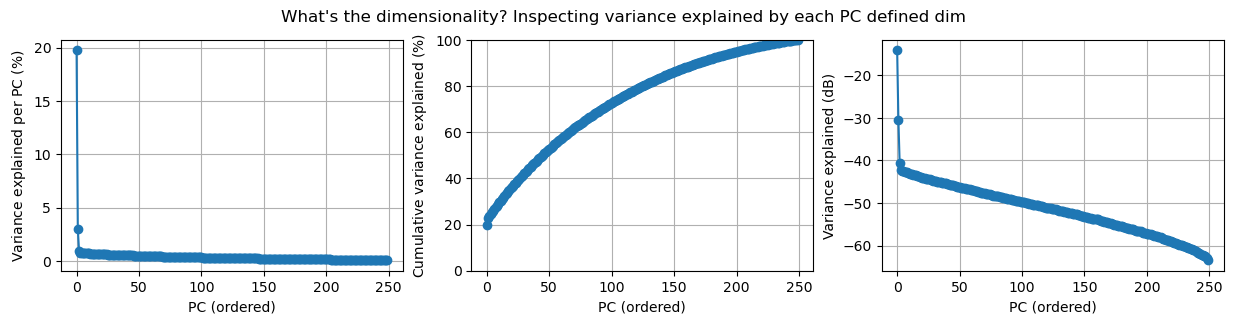

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

axs[0].plot(norm_sv * 100, 'o-')
axs[1].plot(norm_sv.cumsum() * 100, 'o-')
axs[1].set_ylim([0, 100])
axs[2].plot(20*np.log10(norm_sv), 'o-')

[(axs[k].grid(), axs[k].set_title(f''), axs[k].set_xlabel("PC (ordered)")) for k in range(3)]
axs[0].set_ylabel("Variance explained per PC ($\%$)"); 
axs[1].set_ylabel("Cumulative variance explained ($\%$)");
axs[2].set_ylabel("Variance explained (dB)"); 
fig.suptitle("What's the dimensionality? Inspecting variance explained by each PC defined dim");

In [19]:
# visualizing top two PCs
top2u = u[:, :2]
X_hat_PCA = rearrange(top2u, '(trial time) pcs -> trial time pcs', trial=nTrial)

Text(0.5, 1.0, '2D slice')

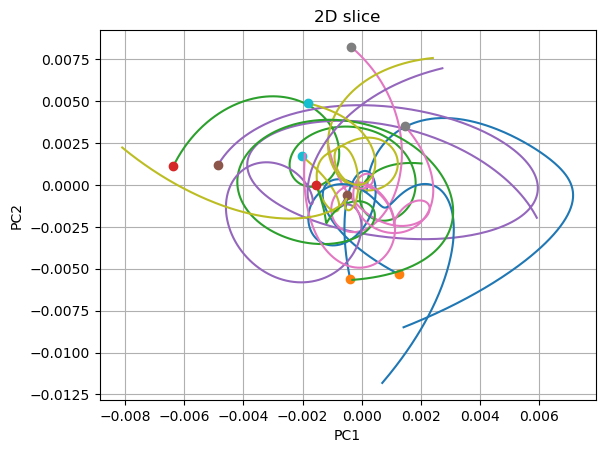

In [20]:
for k in range(10):
    plt.plot(X_hat_PCA[k,:,0],  X_hat_PCA[k,:,1])
    plt.plot(X_hat_PCA[k,-1,0], X_hat_PCA[k,-1,1], 'o')
    
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.grid(); plt.title('2D slice')

## GPFA

We are using the implementation included in the Elephant package:
https://elephant.readthedocs.io/en/latest/reference/gpfa.html

 - Yu, B. M., Cunningham, J. P., Santhanam, G., Ryu, S. I., Shenoy, K. V., & Sahani, M. (2009). Gaussian-process factor analysis for low-dimensional single-trial analysis of neural population activity. Journal of Neurophysiology, 102(1), 614–635.

In [23]:
from elephant.gpfa import GPFA
import neo
import quantities as pq

In [24]:
# ---- Convert to neo.SpikeTrains ---- #
def array_to_spiketrains(array, bin_size):
    """Convert B x T x N spiking array to list of list of SpikeTrains"""
    stList = []

    for trial in range(array.shape[0]):
        trialList = []
        for channel in range(array.shape[2]):
            times = np.nonzero(array[trial, :, channel])[0]
            counts = array[trial, times, channel].astype(int)
            times = np.repeat(times, counts)
            st = neo.SpikeTrain(times*bin_size, t_stop=array.shape[1]*bin_size)
            trialList.append(st)
        stList.append(trialList)
    return stList

Y_st_train = array_to_spiketrains(y, dt*pq.s)

In [25]:
# ---- Run GPFA ---- #
nLatents = 2
gpfa = GPFA(bin_size=(dt * pq.s), x_dim=nLatents)
gpfa_val_result = gpfa.fit_transform(Y_st_train, returned_data=['latent_variable', 'VsmGP'])
length_scales = gpfa.params_estimated['gamma']

/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/elephant/utils.py:291: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/elephant/utils.py:291: UserWarning: Correcting 2 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/elephant/utils.py:291: UserWarning: Correcting 3 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '


Initializing parameters using factor analysis...

Fitting GPFA model...


/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/elephant/utils.py:291: UserWarning: Correcting 1 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/elephant/utils.py:291: UserWarning: Correcting 2 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '
/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/elephant/utils.py:291: UserWarning: Correcting 3 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
  warnings.warn(f'Correcting {num_corrections} rounding errors by '


In [26]:
X_hat_GPFA = rearrange(np.stack(gpfa_val_result['latent_variable'], 0), 'trials lat time -> trials time lat')
P_hat_GPFA = rearrange(np.stack(gpfa_val_result['VsmGP'], 0)[:, np.arange(X_hat_GPFA.shape[1]), np.arange(X_hat_GPFA.shape[1])], 'trials time lat -> trials time lat')

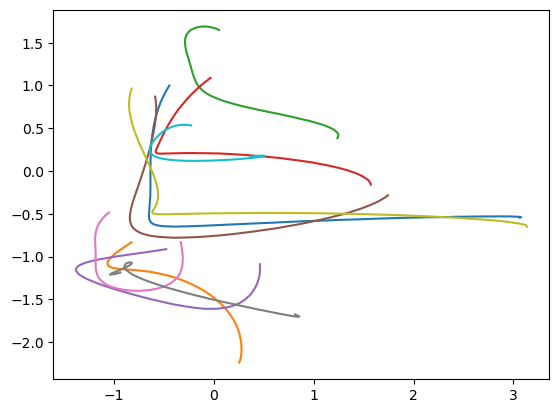

In [27]:
for k in range(10):
    plt.plot(X_hat_GPFA[k,:,0], X_hat_GPFA[k,:,1])

## vLGP

 - Zhao, Y., & Park, I. M. (2017). Variational Latent Gaussian Process for Recovering Single-Trial Dynamics from Population Spike Trains. Neural Computation, 29(5), 1293–1316.
 - Nam, H. (2015). Poisson Extension of Gaussian Process Factor Analysis for Modelling Spiking Neural Populations (J. Macke (ed.)). Eberhard-Karls-Universität Tübingen.

In [28]:
from vlgpax.kernel import RBF
from vlgpax import Session, vi

In [29]:
session = Session(dt)

# Session is the top level container of data. Two arguments, binsize and unit of time, are required at construction.
for i, yy in enumerate(y):
    session.add_trial(i + 1, y = yy)  # Add trials to the session.

# Build the model
kernel = RBF(scale = 1., lengthscale = 25 * dt)  # RBF kernel

In [30]:
random_seed = 20221011
np.random.seed(random_seed)
session, params = vi.fit(session, n_factors=nLatents, kernel=kernel, seed=random_seed, max_iter=50)

Initializing
Initialized


/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/vlgpax/vi.py:267: UserWarning: M: loss increased
  warnings.warn('M: loss increased')
/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/vlgpax/vi.py:160: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


EM Iteration 1, 	Loss = 8.2996, 	M step: 15.36s, 	E step: 56.24s
EM Iteration 2, 	Loss = 5.4722, 	M step: 15.92s, 	E step: 53.80s
EM Iteration 3, 	Loss = 5.4542, 	M step: 9.50s, 	E step: 40.25s
EM Iteration 4, 	Loss = 5.4511, 	M step: 6.60s, 	E step: 48.55s
EM Iteration 5, 	Loss = 5.4506, 	M step: 8.07s, 	E step: 53.51s
EM Iteration 6, 	Loss = 5.4508, 	M step: 6.42s, 	E step: 51.96s
Inferring


/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/vlgpax/vi.py:405: UserWarning: EM: loss increased
  warnings.warn('EM: loss increased')


Trial 1, 	Loss = 5.8111
Trial 2, 	Loss = 1.4186


/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/vlgpax/vi.py:160: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


Trial 3, 	Loss = 7.0751
Trial 4, 	Loss = 8.2248
Trial 5, 	Loss = 5.2552
Trial 6, 	Loss = 5.2348
Trial 7, 	Loss = 2.7554
Trial 8, 	Loss = 3.7477
Trial 9, 	Loss = 3.8410
Trial 10, 	Loss = 4.2934
Trial 11, 	Loss = 4.3795
Trial 12, 	Loss = 5.9887
Trial 13, 	Loss = 7.2853
Trial 14, 	Loss = 6.1206
Trial 15, 	Loss = 5.1588
Trial 16, 	Loss = 6.7529
Trial 17, 	Loss = 6.1663
Trial 18, 	Loss = 7.2667
Trial 19, 	Loss = 6.0050
Trial 20, 	Loss = 4.5022
Trial 21, 	Loss = 4.5924
Trial 22, 	Loss = 6.6677
Trial 23, 	Loss = 7.3679
Trial 24, 	Loss = 6.2505
Trial 25, 	Loss = 5.2202
Trial 26, 	Loss = 6.4825
Trial 27, 	Loss = 4.9845
Trial 28, 	Loss = 7.3736
Trial 29, 	Loss = 5.7070
Trial 30, 	Loss = 5.7137
Trial 31, 	Loss = 6.3931
Trial 32, 	Loss = 5.8663
Trial 33, 	Loss = 4.5351
Trial 34, 	Loss = 4.8981
Trial 35, 	Loss = 5.9561
Trial 36, 	Loss = 4.4069
Trial 37, 	Loss = 6.6673
Trial 38, 	Loss = 5.2484
Trial 39, 	Loss = 2.5646
Trial 40, 	Loss = 5.7339
Trial 41, 	Loss = 5.4637
Trial 42, 	Loss = 5.0800
Trial 4

In [31]:
X_hat_VLGP = rearrange(session.z, '(trials time) lat -> trials time lat', time=nT)
P_hat_VLGP = rearrange(session.v, '(trials time) lat -> trials time lat', time=nT)

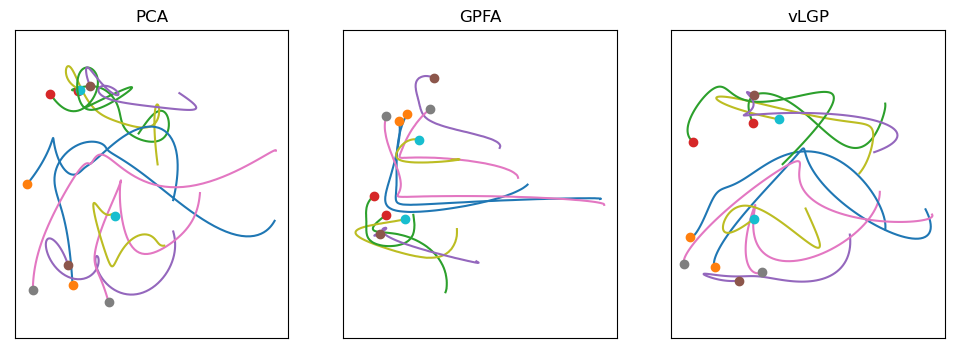

In [32]:
plt.subplots(1,3,figsize=(12,4))

plt.subplot(1,3,1)
for k in range(10):
    plt.plot(X_hat_PCA[k,:,0],  X_hat_PCA[k,:,1])
    plt.plot(X_hat_PCA[k,-1,0], X_hat_PCA[k,-1,1], 'o')
plt.xticks([]); plt.yticks([]); plt.gca().axis('equal')
plt.title('PCA')
    
plt.subplot(1,3,2)
for k in range(10):
    plt.plot(X_hat_GPFA[k,:,0],  X_hat_GPFA[k,:,1])
    plt.plot(X_hat_GPFA[k,-1,0], X_hat_GPFA[k,-1,1], 'o')
plt.xticks([]); plt.yticks([]); plt.gca().axis('equal')
plt.title("GPFA");
        
plt.subplot(1,3,3)
for k in range(10):
    plt.plot(X_hat_VLGP[k,:,0],  X_hat_VLGP[k,:,1])
    plt.plot(X_hat_VLGP[k,-1,0], X_hat_VLGP[k,-1,1], 'o')
plt.xticks([]); plt.yticks([]); plt.gca().axis('equal')
plt.title("vLGP");

In [33]:
m5.close() # closing the data file

### Evaluating LVMs
One simple metric to evaluate the capability of these LVMs is the expected log-likelihood given by

$$
\ell(m_{1:T}, P_{1:T}) = \sum\nolimits_t \mathbb{E}_{q(z_t; \,m_t, P_t)} \log p(y_t \mid z_t)
$$

Recall that for PCA, the `posterior' degrades into a point estimate, so that we should supply $P_t = 0$ when evaluating PCA


In [34]:
import code_pack.utils as utils

readout_iter = 500
C_GPFA = utils.estimate_readout_matrix(y, X_hat_GPFA, None, dt, readout_iter)
ell_GPFA = utils.expected_ll_poisson(y, X_hat_GPFA, P_hat_GPFA, C_GPFA, dt)

C_PCA = utils.estimate_readout_matrix(y, X_hat_PCA, None, dt, readout_iter)
ell_PCA = utils.expected_ll_poisson(y, X_hat_PCA, np.zeros_like(P_hat_GPFA), C_PCA, dt)

C_vLGP = utils.estimate_readout_matrix(y, np.asarray(X_hat_VLGP), None, dt, readout_iter)
ell_vLGP = utils.expected_ll_poisson(y, np.asarray(X_hat_VLGP), np.asarray(P_hat_VLGP), C_vLGP, dt)

print(f'PCA ell: {ell_PCA}')
print(f'GPFA ell: {ell_GPFA}')
print(f'VLGP ell: {ell_vLGP}')

PCA ell: 7.170300483703613
GPFA ell: 63.1828727722168
VLGP ell: 101.6765365600586


In [47]:
velocity_train = np.load('mc_maze/data/velocity_per_trial_train.npy')
rates_PCA = dt * np.exp(C_PCA(torch.tensor(X_hat_PCA, dtype=torch.float32)).detach().numpy())
gscv_PCA = GridSearchCV(Ridge(), {'alpha': np.logspace(-7, -1, 100)})
gscv_PCA.fit(rates_PCA.reshape(-1, nNeuron), velocity_train.reshape(-1, 2))

rates_GPFA = dt * np.exp(C_GPFA(torch.tensor(X_hat_GPFA, dtype=torch.float32)).detach().numpy())
gscv_GPFA = GridSearchCV(Ridge(), {'alpha': np.logspace(-7, -1, 100)})
gscv_GPFA.fit(rates_GPFA.reshape(-1, nNeuron), velocity_train.reshape(-1, 2));

rates_vLGP = 5e-3 * np.exp(C_vLGP(torch.tensor(np.asarray(X_hat_VLGP), dtype=torch.float32)).detach().numpy())
gscv_vLGP = GridSearchCV(Ridge(), {'alpha': np.logspace(-7, -1, 100)})
gscv_vLGP.fit(rates_vLGP.reshape(-1, nNeuron), velocity_train.reshape(-1, 2));

/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.08538e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.72244e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.03651e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/tushar/anaconda3/envs/lvmworkshop/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=2.79259e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="po

In [49]:
predicted_velocity_pca = np.zeros((nTrial, nT, 2))
predicted_velocity_gpfa = np.zeros((nTrial, nT, 2))
predicted_velocity_vlgp = np.zeros((nTrial, nT, 2))

for n in range(nTrial):
    predicted_velocity_pca[n] = gscv_PCA.predict(dt * np.exp(C_PCA(torch.tensor(X_hat_PCA[n], dtype=torch.float32)).detach().numpy()))
    predicted_velocity_gpfa[n] = gscv_GPFA.predict(dt * np.exp(C_GPFA(torch.tensor(X_hat_GPFA[n], dtype=torch.float32)).detach().numpy()))
    predicted_velocity_vlgp[n] = gscv_vLGP.predict(dt * np.exp(C_vLGP(torch.tensor(np.asarray(X_hat_VLGP)[n], dtype=torch.float32)).detach().numpy()))

predicted_trajectory_pca = np.cumsum(predicted_velocity_pca, axis=1) * dt
predicted_trajectory_gpfa = np.cumsum(predicted_velocity_gpfa, axis=1) * dt
predicted_trajectory_vlgp = np.cumsum(predicted_velocity_vlgp, axis=1) * dt

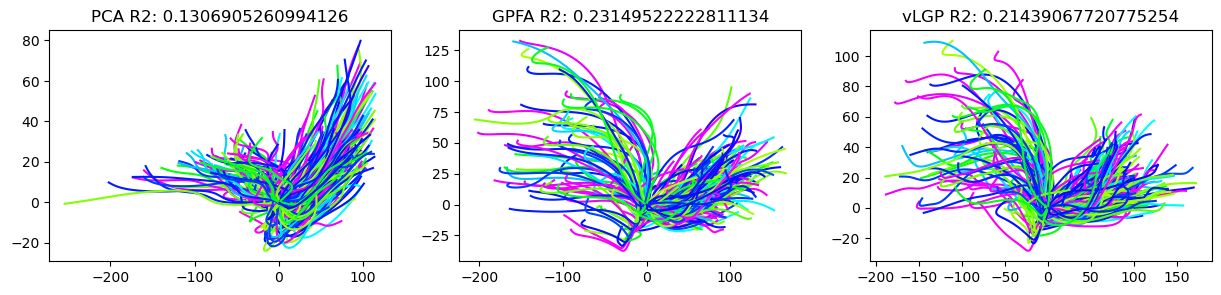

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

for i in range(nTrial - 1):
    line_color = trial_info_train.iloc[i]['color']
    axs[0].plot(predicted_trajectory_pca[i, :, 0], predicted_trajectory_pca[i, :, 1], color=line_color)
    axs[1].plot(predicted_trajectory_gpfa[i, :, 0], predicted_trajectory_gpfa[i, :, 1], color=line_color)
    axs[2].plot(predicted_trajectory_vlgp[i, :, 0], predicted_trajectory_vlgp[i, :, 1], color=line_color)

axs[0].set_title(f'PCA R2: {gscv_PCA.best_score_}')
axs[1].set_title(f'GPFA R2: {gscv_GPFA.best_score_}')
axs[2].set_title(f'vLGP R2: {gscv_vLGP.best_score_}')
plt.show()